[< 01 - Intro to Bookworm](01%20-%20Intro%20to%20Bookworm.ipynb) | [Home](https://github.com/harrisonpim/bookworm) | [03 - Visualising and Analysing Networks >](03%20-%20Visualising%20and%20Analysing%20Networks.ipynb)  

# Character Building
We want to be able to automate the entirity of the bookworm process, and manually inputting a list of characters to the program feels a lot like cheating. Getting over this hurdle means that we need to form a list of characters (or at least _plausible_ characters) from the raw text of the book alone. This is an inherently rough task and any solution is going to be inexact, so it's reasonable to feel sceptical about its feasibility at this point. However, I think that the results at the end of the process make it worth explaining. 

First we need to import everything from bookworm that we went through in the last notebook, and some new stuff that we'll use to interpret the novel's language - most notably NLTK and Spacy.

In [1]:
from bookworm import *

In [2]:
import pandas as pd
import networkx as nx

import spacy
import nltk
import string

Lets start by loading in a book and splitting it into sentences

In [3]:
book = load_book('data/raw/fellowship_of_the_ring.txt')
sequences = get_sentence_sequences(book)

### Name Extraction
The solution uses a little bit of creativity and a whole load of brute-force.  
A sensible place to start when looking for character names is to go and find _proper nouns_. Part-of-speech tagging is a pretty well known NLP technique which does just that - it assigns a tag to each word in a string according to its _type_ - noun, verb, adverb etc ([you can read more about part-of-speech tagging here](https://en.wikipedia.org/wiki/Part-of-speech_tagging)). [Spacy](https://spacy.io/) has a pretty good POS tagger - having messed around with both Spacy and NLTK, I can say that with confidence that Spacy's is currently the more adept tagger. If we run this over the whole book and grab everything tagged as `'PROPN'` we'll return a list of plausible proper nouns.  
This process could take a while, given that we have this many individual words to interpret and tag:

In [4]:
len(book.split())

188116

It makes more sense to start with a stripped down list of the _unique_ words which appear in the text. That way, we only have to tag each word once. We should also get strip out all punctuation from the words before we start.

In [5]:
remove_punctuation = lambda s: s.translate(str.maketrans('', '', string.punctuation+'’'))
words = [remove_punctuation(p) for p in book.split()]

unique_words = list(set(words))
len(unique_words)

10531

Now we can grab those `'PROPN'` tagged words

In [6]:
nlp = spacy.load('en')

candidates = [word.text for word in nlp(' '.join(unique_words)) if word.pos_ == 'PROPN']
len(candidates)

1355

We're looking for names, and it's unlikely that our English-language books will include any characters whose names are shorter than 2 characters. We should get rid of those from our list of proper nouns...

In [7]:
candidates = [c for c in candidates if len(c) > 2]
len(candidates)

1331

I've noticed that Spacy will occasionally tag non-title-case words as proper nouns, which is odd. Character names will typically be capitalised so we'll get rid of anything which isn't. We're relying on authors' 'proper' use of English language conventions here, which aren't always going to be perfect, but that's part of the joy of this project; we can still make a decent approximation of the truth despite the messiness of the initial data.

In [8]:
candidates = [c for c in candidates if c.istitle()]
len(candidates)

1251

I've also noticed that when dealing with characters in so many contexts, we'll sometimes get characters appearing as themselves and as posessives (ie `Frodo` and `Frodo's`). After stripping out punctuation we'll see `Frodo` and `Frodos`, so we just have to get rid of those words which end in `s` but are otherwise duplicates of other words already in the list.

In [9]:
candidates = [c for c in candidates if not (c[-1] == 's' and c[:-1] in candidates)]
len(candidates)

1159

NLTK includes a load of _stop words_ which we can compare our list against. Stop words are commonly occurring English words like 'the' or 'in' which are very unlikely to overlap with our characters' names. Strip them out...

In [10]:
stopwords = nltk.corpus.stopwords.words('english')

candidates = list(set([c.title() for c in [c.lower() for c in candidates]]) - set(stopwords))

len(candidates)

1159

In [11]:
candidates[:10]

['Whitfoot',
 'Hallo',
 'Haldir',
 'Dad',
 'Leap',
 'Valandil',
 'Sickle',
 'Till',
 'Tindrock',
 'Buck']

All that remains to be done is to get them into the usual form that bookworm expects (a list of tuples). We'll call this our list of characters.

In [12]:
characters = [tuple([character + ' ']) for character in set(candidates)]

Obviously this is a _significantly_ longer list than what we usually deal with when we list characters manually, and it's a lot less precise (fore- and surnames won't be connected, nicknames won't be attached to their characters etc), but it's a pretty good trade-off for the lack of required contextual knowledge before starting the analysis. You'll also notice that a few 'names' aren't actually names - they're normal words that have somehow managed to slip through the gauntlet. As we move into the typical bookworm analysis process below, we'll see that this doesn't significantly affect the final results.

# Standard Analysis & Comparisons to Manual Character Assignment
We can now throw our list of automatically collected characters and our usual sequences into the usual bookworm analysis process: finding connections between characters and sequences and then connections between characters and characters. Finally we'll set up a dataframe of interactions which can be passed to NetworkX to visualise (we'll go through the last bit of this process in much more detail in [the next notebook](03%20-%20Visualising%20and%20Analysing%20Networks.ipynb).

Because we're now dealing with a much longer list of characters, the computation will take longer (the cooccurence matrix calculation scales quadratically with the number of characters). It should still run comfortably on a decent laptop.

In [13]:
df = find_connections(sequences, characters)
cooccurence = calculate_cooccurence(df)

the next step gets the network into a form that is neatly interpreted by NetworkX

In [14]:
interaction_df = get_interaction_df(cooccurence, threshold=1)
interaction_df.sample(5)

,source,target,value
496492,"('Frodo ',)","('Gandalf ',)",13
296453,"('East ',)","('Shire ',)",2
58258,"('Bag ',)","('End ',)",23
743685,"('Maggot ',)","('Old ',)",2
496246,"('Frodo ',)","('Company ',)",2


We can import a few things to help visualise the graph that we've put together

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,9)

/home/harrisonpim/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnin

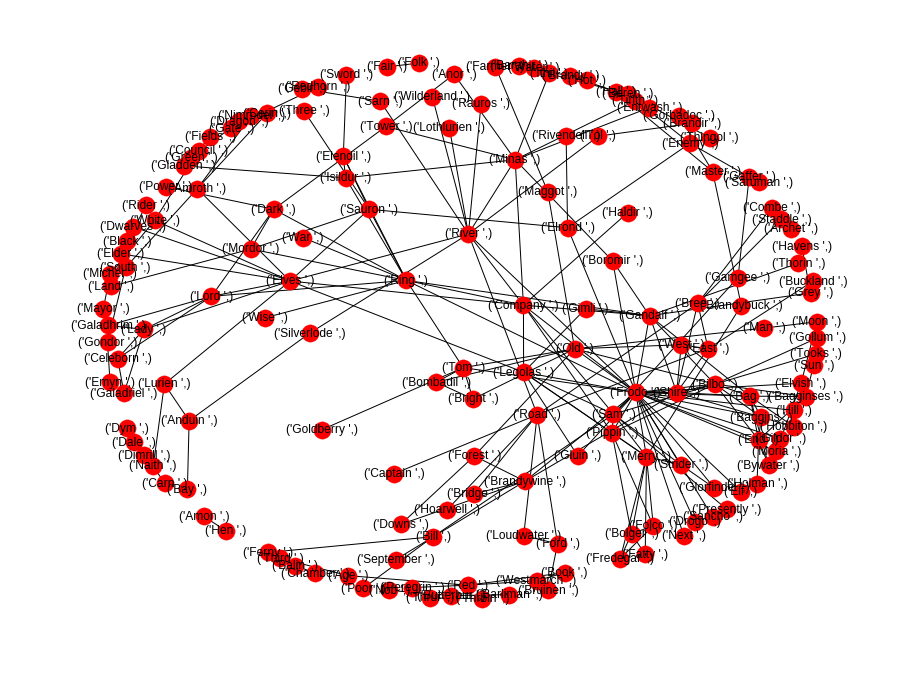

In [16]:
G = nx.from_pandas_dataframe(interaction_df,
                             source='source',
                             target='target')

nx.draw(G, with_labels=True)

We can calculate the importance of the characters using the pagerank algorithm included in NetworkX

In [17]:
pd.Series(nx.pagerank(G)).sort_values(ascending=False)[:10]

('Frodo ',)      0.042858
('River ',)      0.020977
('Elves ',)      0.019907
('Ring ',)       0.019211
('Minas ',)      0.016500
('Bilbo ',)      0.016271
('Sam ',)        0.015427
('Road ',)       0.015238
('Company ',)    0.015060
('Gandalf ',)    0.014947
dtype: float64

I was stunned when I saw the results that this process produces. It's such a rough process for character naming, but all of the main characters' names are there, the process generalises to many different novels, authors and styles, and the weights attributed to the character interactions all seem quite reasonable. 

I was expecting all of the hundreds (often thousands) of plausible names to be included in the graph, lurking around, connecting legitimate characters who have no right to be connected according to the source text. I was also expecting the non-character-name-words to be much more prevalent. I'd forgotten, though, that the bookworm process relies on the close coocurrence of characters to form connections - those illegitimate, non-character-name-words are therefore very unlikely to accumulate significant scores with many (or indeed any) legitimate characters so the imposition of a low threshold sweeps away any spurious connections. In the end we're left with a very reasonable result.

### Place Names, Group Names
Another lovely feature of this process is the inclusion of place names (`Minas` and `Road` above).  
I've [observed in the past](https://twitter.com/hmpim/status/909680260270231552) that in cases where we have hundreds of characters with interwoven narratives or storylines, the graph begins to resemble the geography of the world that the characters inhabit. In the case linked to above, the graph for _A Game of Thrones_ begins to resemble the map of the fantasy world of Westeros/Essos, with stories (and narrative clusters) separated by the Narrow Sea.  
The example above is particularly interesting in that the _fantacy races_ (`Elves`, `Men`) of the characters have been extracted as names and emerge as being structurally important to the network.

### Caveats
It's not perfect yet...  
- The algorithm doesn't know whether names represent characters or places or something entrirely different. In some ways this is great, but in others it can be frustrating.
- Although we're surprisingly unlikely to see illegitimate character names in the final graph, it does happen occasionally. 
- We can't yet automatically define the limit for what a 'significant' relationship is in a novel, and the threshold for the final visualisation usually involves a bit of tuning before it settles at a reasonable level.
- The process isn't that fast, and a long list of plausible character names contributes to significant slow downs later on.

# Wrapping Up
We can wrap up all of our useful code from the sections above into a single function to extract character names from books:

In [18]:
def extract_character_names(book):
    '''
    Automatically extracts lists of plausible character names from a book

    Parameters
    ----------
    book : string (required)
        book in string form (with original upper/lowercasing intact)

    Returns
    -------
    characters : list
        list of plasible character names
    '''
    nlp = spacy.load('en')
    stopwords = nltk.corpus.stopwords.words('english')

    words = [remove_punctuation(w) for w in book.split()]
    unique_words = list(set(words))

    characters = [word.text for word in nlp(' '.join(unique_words)) if word.pos_ == 'PROPN']
    characters = [c for c in characters if len(c) > 2]
    characters = [c for c in characters if c.istitle()]
    characters = [c for c in characters if not (c[-1] == 's' and c[:-1] in characters)]
    characters = list(set([c.title() for c in [c.lower() for c in characters]]) - set(stopwords))

    return [tuple([c + ' ']) for c in set(characters)]

In [19]:
book = load_book('data/raw/fellowship_of_the_ring.txt', lower=False)

In [20]:
extract_character_names(book)[-10:]

[('Gildor ',),
 ('Neither ',),
 ('Age ',),
 ('Enchantment ',),
 ('Woodelves ',),
 ('Thranduil ',),
 ('Springlering ',),
 ('Amon ',),
 ('Flow ',),
 ('Calaciryo ',)]

In [21]:
%%timeit
extract_character_names(book)

4.56 s ± 254 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As I said, the process isn't instantaneous. However, it's barely been optimised at this stage and the payoff for those few seconds is _enormous_ if we're interpreting an unseen book.

In the next notebook, we'll have a go at doing some deeper analysis of the networks we've built and visualising them with NetworkX and d3.js  
[< 01 - Intro to Bookworm](01%20-%20Intro%20to%20Bookworm.ipynb) | [Home](https://github.com/harrisonpim/bookworm) | [03 - Visualising and Analysing Networks >](03%20-%20Visualising%20and%20Analysing%20Networks.ipynb)